# Before running this notebook
For the validation phase, this notebook needs only the csv.num files that can be generated by running several iterations, in the root directory, of:

## "cotr_pipeline.sh" 

Iteration 1: 
`level="eukaryota"
tree="raxml"
ladder=("RL" "LL" "NL")`

Iteration 2:
`level="Eukaryota"
tree="(ncbi)"
ladder=("RL" "LL" "NL")`

Iteration 3: 
`level="Eukaryota"
tree="random"
ladder=("RL" "LL" "NL")`

## "cotr_pipeline_OMA.sh"

Iteration 4: 
`level="eukaryota"
taxonomy_database='ncbi' 
tree="raxml"
ladder=("RL" "LL" "NL")`

# Import and variables

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
from multiprocessing import Pool
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import itertools
import glob
import tqdm

from omadb import Client
from Bio import Entrez

In [2]:
os.chdir('validation/')

# Raw files download
- HogProf yeast analysis dataset
- OrthoDB orthogroup to genes
- OrthoDB gene xrefs
- Sc R64 FASTA
- Sc YJM1573 FASTA
- Sc R64 Uniprot to Ensembl

In [3]:
%%time

if f'odb10v1_gene_xrefs.tab.gz.YJM1573' not in os.listdir():

    # validation sets
    !curl -O https://raw.githubusercontent.com/DessimozLab/HogProf/master/src/HogProf/validation_set/TaSuppData/humanwopt.csv
    !curl -O https://raw.githubusercontent.com/DessimozLab/HogProf/master/src/HogProf/validation_set/TaSuppData/yeastw_opt.csv

    # fastas and xref file download
    !curl -O http://ftp.ensembl.org/pub/release-106/fasta/saccharomyces_cerevisiae/pep/Saccharomyces_cerevisiae.R64-1-1.pep.all.fa.gz
    !curl -O http://ftp.ensemblgenomes.org/pub/fungi/release-53/fasta/fungi_ascomycota2_collection/saccharomyces_cerevisiae_yjm1573_gca_000978255/pep/Saccharomyces_cerevisiae_yjm1573_gca_000978255.Sc_YJM1573_v1.pep.all.fa.gz
    !curl -O http://ftp.ensembl.org/pub/current_tsv/saccharomyces_cerevisiae/Saccharomyces_cerevisiae.R64-1-1.108.uniprot.tsv.gz

    !gunzip Saccharomyces_cerevisiae.R64-1-1.pep.all.fa.gz
    !gunzip Saccharomyces_cerevisiae_yjm1573_gca_000978255.Sc_YJM1573_v1.pep.all.fa.gz
    !gunzip Saccharomyces_cerevisiae.R64-1-1.108.uniprot.tsv.gz

    !curl -O https://v101.orthodb.org/download/odb10v1_OG2genes.tab.gz
    !curl -O https://v101.orthodb.org/download/odb10v1_gene_xrefs.tab.gz

    !zgrep 1294385_1 odb10v1_OG2genes.tab.gz > odb10v1_OG2genes.tab.gz.YJM1573
    !zgrep 1294385_1 odb10v1_gene_xrefs.tab.gz > odb10v1_gene_xrefs.tab.gz.YJM1573

    !zgrep 9606_0 odb10v1_gene_xrefs.tab.gz > odb10v1_gene_xrefs.9606.tab
    !zgrep 9606_0 odb10v1_OG2genes.tab.gz > odb10v1_OG2genes.9606.tab

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7030k  100 7030k    0     0  8336k      0 --:--:-- --:--:-- --:--:-- 8330k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1612k  100 1612k    0     0  3941k      0 --:--:-- --:--:-- --:--:-- 3942k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2636k  100 2636k    0     0   404k      0  0:00:06  0:00:06 --:--:--  403k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1784k  100 1784k    0     0   419k      0  0:00:04  0:00:04 --:--:--  428k
  % Total    % Received % Xferd  Average Speed   Tim

# BLAST (yeast)
- `Saccharomyces_cerevisiae.R64-1-1` (Uniprot)
- `Saccharomyces_cerevisiae_yjm1573` (OrthoDB)

In [4]:
%%time

# given the different strain used by orthodb, uniprot and ensembl
# mapping the ogs through a BLAST

outblast = 'ye288ye1573'
outmapped = 'ye288ye1573.mapped'
ye1573_file = 'Saccharomyces_cerevisiae_yjm1573_gca_000978255.Sc_YJM1573_v1.pep.all.fa'
ye288_file = 'Saccharomyces_cerevisiae.R64-1-1.pep.all.fa'
validation_file = 'yeastw_opt.csv'
ye288_xref_file = 'Saccharomyces_cerevisiae.R64-1-1.108.uniprot.tsv'

if outblast not in os.listdir():

    !makeblastdb -in {ye1573_file} -dbtype 'prot'
    !blastp -query {ye288_file} -db {ye1573_file} -out {outblast} -outfmt=6 -max_target_seqs 6 -num_threads 32

blast = pd.read_table(outblast, header=None)[[0,1,2,10,11]]
blast.columns = ['gene1','gene2','percid','eval','bitscore']

if outmapped not in os.listdir():

    # bitscore priority with the same og ids and uniprot ids
    # allowed multiple ogs if associated to different uniprot ids

    odbxref = pd.read_table('odb10v1_gene_xrefs.tab.gz.YJM1573', header=None)
    odbxref[1] = odbxref[1].apply(lambda x: x.split('.')[0])
    odbxref = odbxref[odbxref[2]=='NCBIproteinAcc']
    odbxrefs = dict(odbxref[[1,0]].values)

    odbgene = pd.read_table('odb10v1_OG2genes.tab.gz.YJM1573', header=None)
    odbgene = odbgene[odbgene[0].str.endswith('at2759')]

    blast = pd.merge(blast, odbxref[[0,1]].rename(
        columns={1: 'gene2', 0: 'odb2'}))
    blast = pd.merge(blast, odbgene.rename(
        columns={0: 'og2', 1: 'odb2'}))
    xref = pd.read_table(ye288_xref_file)
    blast = pd.merge(blast, xref[['xref','gene_stable_id']].rename(
        columns={'xref': 'uni1', 'gene_stable_id': 'gene1'}))

    yeast = pd.read_table(validation_file, sep=',')
    alluni = set(yeast['ProA'].tolist()+yeast['proB'].tolist())
    blast = blast[blast['uni1'].isin(alluni)]

    blast2 = blast[blast['eval']<=1e-2][blast['percid']>=70]
    b1 = blast2.sort_values('bitscore', ascending=False
                           ).drop_duplicates('uni1')

    yeast = pd.read_table(validation_file, sep=',').iloc[:,3:]
    yeast1 = pd.merge(yeast, b1[['uni1','og2']], 
                      left_on='ProA', right_on='uni1')
    yeast1 = pd.merge(yeast1, b1[['uni1','og2']], 
                      left_on='proB', right_on='uni1')
    yeast1 = yeast1.drop(['uni1_x','uni1_y'], axis=1
                        ).rename(columns={
        'og2_x': 'og1', 'og2_y': 'og2'})
    yeast1 = yeast1.drop_duplicates()
    yeast1.to_csv(outmapped, sep='\t', index=None)



Building a new DB, current time: 01/30/2023 17:22:31
New DB name:   /hpc/group/G_BIOSCIENZE/Cotransitions/Notebook_python/validation_update_newzenodo/validationzenodo/Saccharomyces_cerevisiae_yjm1573_gca_000978255.Sc_YJM1573_v1.pep.all.fa
New DB title:  Saccharomyces_cerevisiae_yjm1573_gca_000978255.Sc_YJM1573_v1.pep.all.fa
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 5451 sequences in 0.330319 seconds.


CPU times: user 1.62 s, sys: 645 ms, total: 2.27 s
Wall time: 1min 42s


In [5]:
%%time

og2geneshuman = pd.read_table('odb10v1_OG2genes.9606.tab', header=None)
xrefhuman = pd.read_table('odb10v1_gene_xrefs.9606.tab', header=None)

val = pd.read_table('humanwopt.csv', sep=',')
valproteins = set(val['ProA'].tolist()+val['proB'].tolist())
xrefhumanval = xrefhuman[xrefhuman[1].isin(valproteins)]
xrefhumanvalogs = pd.merge(xrefhumanval[[0,1]].rename(columns={0:1,1:2}), 
                           og2geneshuman)[[2,0]]
xrefhumanvalogseu = xrefhumanvalogs[xrefhumanvalogs[0].str.contains('at2759')]
xrefhumanvalogseudict = dict(xrefhumanvalogseu.values.tolist())
val['og1'] = val['ProA'].apply(lambda x: xrefhumanvalogseudict.get(x))
val['og2'] = val['proB'].apply(lambda x: xrefhumanvalogseudict.get(x))

val.to_csv(f'humanwopt_odb.tsv', sep='\t', index=False)

df = pd.read_table('ye288ye1573.mapped')
df.to_csv(f'yeastwopt_odb.tsv', sep='\t', index=False)

CPU times: user 996 ms, sys: 71.2 ms, total: 1.07 s
Wall time: 1.68 s


# Validation

In [6]:
tree = glob.glob('../../Eukaryota*raxml*num')
ncbi = glob.glob('../../Eukaryota*ncbi*num')
rand = glob.glob('../../Eukaryota*random*num')

todo = []
for typ in ['yeast','human']:
    for name, csvs in zip(['raxml','ncbi','random'], [tree, ncbi, rand]):
        for csv1 in csvs:
            csv2 = 'yeastwopt_odb.tsv' if typ == 'yeast' else 'humanwopt_odb.tsv'
            exfile = f'{os.path.basename(csv1)}.{typ}'.replace('raxml', name)
            todo.append([csv1, csv2, exfile, typ])
            
def do_validation(csvs):
    csv1, csv2, exfile, typ = csvs[0], csvs[1], csvs[2], csvs[3]
    
    !python3 get_transitions_validation.py {csv1} {csv2} | procedure_Orthodb_Fisher.r -p 1 -pa 1 - > {exfile}
    !python3 get_transitions_validation.py {csv1} {csv2} -c | procedure_Orthodb_Fisher.r -p 1 -pa 1 - > {exfile}.C
    !python3 get_transitions_validation_jaccard_pearson.py {csv1} {csv2} > {os.path.basename(csv1)}.{typ}.jaccpear
    
list(tqdm.tqdm(Pool(9).imap(do_validation, todo), total=len(todo)))

  0%|          | 0/20 [00:00<?, ?it/s]

done transitions
done transitions
done concordance
done concordance
calculating probabilities (output table to STDOUT)
calculating probabilities (output table to STDOUT)
9757 gene pairs with p <= 1 and p.adj <= 1
9757 gene pairs with p <= 1 and p.adj <= 1
done transitions
done concordance
done transitions
done transitions
done concordance
done concordance
done transitions
done concordance
calculating probabilities (output table to STDOUT)
calculating probabilities (output table to STDOUT)
9757 gene pairs with p <= 1 and p.adj <= 1
calculating probabilities (output table to STDOUT)
done transitions
done transitions
done concordance
done concordance
9757 gene pairs with p <= 1 and p.adj <= 1
9757 gene pairs with p <= 1 and p.adj <= 1
calculating probabilities (output table to STDOUT)
calculating probabilities (output table to STDOUT)
9757 gene pairs with p <= 1 and p.adj <= 1
calculating probabilities (output table to STDOUT)
9757 gene pairs with p <= 1 and p.adj <= 1
9757 gene pairs wit

  5%|▌         | 1/20 [02:09<41:07, 129.89s/it]

done concordance
done concordance
done concordance


 10%|█         | 2/20 [02:24<18:37, 62.07s/it] 

done transitions
done concordance
done transitions
done concordance
done transitions
calculating probabilities (output table to STDOUT)
done concordance
done transitions
calculating probabilities (output table to STDOUT)
done transitions
done concordance
done concordance
calculating probabilities (output table to STDOUT)
done transitions
done transitions
done concordance
41636 gene pairs with p <= 1 and p.adj <= 1
calculating probabilities (output table to STDOUT)
done concordance
41636 gene pairs with p <= 1 and p.adj <= 1
41636 gene pairs with p <= 1 and p.adj <= 1
calculating probabilities (output table to STDOUT)
calculating probabilities (output table to STDOUT)
calculating probabilities (output table to STDOUT)
9757 gene pairs with p <= 1 and p.adj <= 1
41636 gene pairs with p <= 1 and p.adj <= 1
41636 gene pairs with p <= 1 and p.adj <= 1
41636 gene pairs with p <= 1 and p.adj <= 1
done transitions
done concordance
calculating probabilities (output table to STDOUT)
0 gene pairs 

 50%|█████     | 10/20 [04:15<03:20, 20.09s/it]

calculating probabilities (output table to STDOUT)
41636 gene pairs with p <= 1 and p.adj <= 1
done concordance
done concordance
done concordance
done concordance
done concordance


 70%|███████   | 14/20 [04:26<01:08, 11.45s/it]

done concordance
done concordance


 85%|████████▌ | 17/20 [04:32<00:21,  7.08s/it]

done concordance


 90%|█████████ | 18/20 [04:47<00:17,  8.82s/it]

done transitions
done concordance
calculating probabilities (output table to STDOUT)
done transitions
41636 gene pairs with p <= 1 and p.adj <= 1
done concordance
calculating probabilities (output table to STDOUT)
41636 gene pairs with p <= 1 and p.adj <= 1
done transitions
done concordance
calculating probabilities (output table to STDOUT)
done transitions
done concordance
41636 gene pairs with p <= 1 and p.adj <= 1
calculating probabilities (output table to STDOUT)
41636 gene pairs with p <= 1 and p.adj <= 1
done concordance


 95%|█████████▌| 19/20 [06:25<00:29, 29.35s/it]

done concordance


100%|██████████| 20/20 [06:29<00:00, 19.50s/it]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [7]:
yeastval = glob.glob('Eukaryota.*.yeast')
yeastvalc = glob.glob('Eukaryota.*.yeast.C')
humanval = glob.glob('Eukaryota.*.human')
humanvalc = glob.glob('Eukaryota.*.human.C')

final = []
for specie in ['yeast','human']:
    
    val = pd.read_table(f'{specie}wopt_odb.tsv')
    lista = yeastval+yeastvalc if specie == 'yeast' else humanval+humanvalc
    for y in tqdm.tqdm(lista):

        if not 'O' in y:

            dy = pd.read_table(y)
            dy['ogs'] = dy.astype(str).apply(lambda x: '|'.join(
                sorted([x['G1'],x['G2']])), axis=1)
            val['ogs'] = val.astype(str).apply(lambda x: '|'.join(
                sorted([x['og1'],x['og2']])), axis=1)
            dyval = pd.merge(dy, val).drop_duplicates(['ProA','proB'])
            dyval = dyval[dyval['og1']!=dyval['og2']]
            dyval['cotr'] = dyval['p'].apply(lambda x: -np.log10(x))
            tree, ladd = y.split('.')[1], y.split('.')[2]
            penalized = True if '.C' in y else False

            for score in ['cotr','EPT_score','Occ_Ed',
                          'Occ_Ps','Bin_Ps','jaccard_hash']:

                sub = dyval[[score,'truth']]
                sub = sub[sub[score]!=np.inf] #################
                y_test = sub.truth
                y_pred = (sub[score]-sub[score].min()
                         )/(sub[score].max()-sub[score].min())
                fpr, tpr, _ = roc_curve(y_test, y_pred)
                roc_auc = auc(fpr, tpr)

                final.append([specie, score, tree, ladd, roc_auc, 
                              fpr, tpr, len(val)-len(dyval), penalized])

final = pd.DataFrame(final)

nonpenyes = final[final[3]=='RL'][final[2]=='raxml'][final[1]=='cotr'][final[0]=='yeast']
nontreeyes = final[final[1]=='cotr'][final[0]=='yeast'][final[8]==False]
nonjaccyes = final[final[2]=='raxml'][final[3]=='RL'][final[1].isin(
    ['cotr','jaccard_hash','EPT_score','Bin_Ps','Occ_Ps','Occ_Ed'])][final[0]=='yeast'][final[8]==False]

nonpenhum = final[final[3]=='RL'][final[2]=='raxml'][final[1]=='cotr'][final[0]=='human']
nontreehum = final[final[1]=='cotr'][final[0]=='human'][final[8]==False]
nonjacchum = final[final[2]=='raxml'][final[3]=='RL'][final[1].isin(
    ['cotr','jaccard_hash','EPT_score','Bin_Ps','Occ_Ps','Occ_Ed'])][final[0]=='human'][final[8]==False]

100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


In [8]:
# define a set of parameters for project uniformity
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6

## Penalized vs non penalized

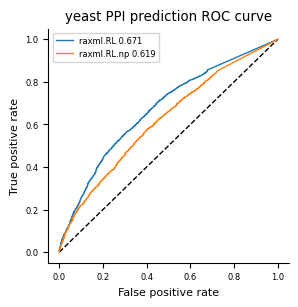

In [9]:
df = nonpenyes

fig, ax1 = plt.subplots(1, 1, figsize=(3.1,3.1), dpi=100)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)

for i, row in enumerate(df.values.tolist()):
    if row[8] == True:
        ax1.plot(row[5], row[6], label=str(f"raxml.RL.np {round(row[4], 3)}"), linewidth=1, alpha=1)
    else:
        ax1.plot(row[5], row[6], label=str(f"raxml.RL {round(row[4], 3)}"), linewidth=1, alpha=1)

ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')

ax1.spines[['right','top']].set_visible(False)
ax1.set_title(f'yeast PPI prediction ROC curve')
plt.legend(loc='upper left')

plt.savefig(f'results.pen.pdf')

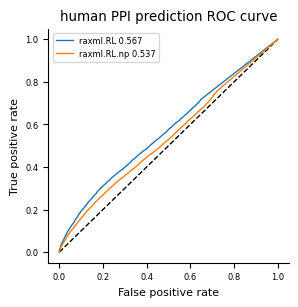

In [10]:
df = nonpenhum

fig, ax1 = plt.subplots(1, 1, figsize=(3.1,3.1), dpi=100)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)

for i, row in enumerate(df.values.tolist()):
    if row[8] == True:
        ax1.plot(row[5], row[6], label=str(f"raxml.RL.np {round(row[4], 3)}"), linewidth=1, alpha=1)
    else:
        ax1.plot(row[5], row[6], label=str(f"raxml.RL {round(row[4], 3)}"), linewidth=1, alpha=1)

ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')

ax1.spines[['right','top']].set_visible(False)
ax1.set_title(f'human PPI prediction ROC curve')
plt.legend(loc='upper left')

plt.savefig(f'results.pen.human.pdf')

## Raxml vs NCBI vs random trees

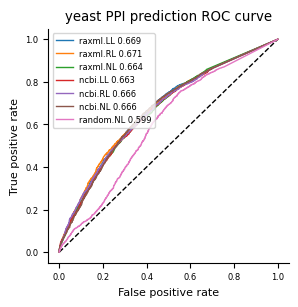

In [11]:
df = nontreeyes

fig, ax1 = plt.subplots(1, 1, figsize=(3.1,3.1), dpi=100)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)

for i, row in enumerate(df[df[2]!='random'].sort_values(2, ascending=False).values.tolist()):
    if not 'Fungi' in row[2]:
        ax1.plot(row[5], row[6], label=str(f"{row[2]}.{row[3]} {round(row[4], 3)}"), linewidth=1, alpha=1)
for i, row in enumerate(df[df[2]=='random'].sort_values(2, ascending=False).values.tolist()):
    ax1.plot(row[5], row[6], label=str(f"{row[2]}.{row[3]} {round(row[4], 3)}"), linewidth=1, alpha=1)
    break

ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')

ax1.spines[['right','top']].set_visible(False)
ax1.set_title(f'yeast PPI prediction ROC curve')
plt.legend(loc='upper left')

plt.savefig(f'results.treencbi.pdf')

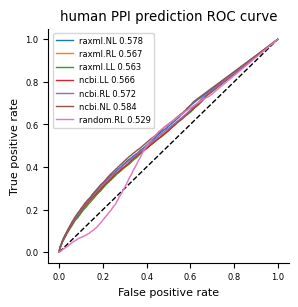

In [12]:
df = nontreehum

fig, ax1 = plt.subplots(1, 1, figsize=(3.1,3.1), dpi=100)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)

for i, row in enumerate(df[df[2]!='random'].sort_values(2, ascending=False).values.tolist()):
    if not 'Metazoa' in row[2]:
        ax1.plot(row[5], row[6], label=str(f"{row[2]}.{row[3]} {round(row[4], 3)}"), linewidth=1, alpha=1)
for i, row in enumerate(df[df[2]=='random'].sort_values(2, ascending=False).values.tolist()):
    ax1.plot(row[5], row[6], label=str(f"{row[2]}.{row[3]} {round(row[4], 3)}"), linewidth=1, alpha=1)
    break

ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')

ax1.spines[['right','top']].set_visible(False)
ax1.set_title(f'human PPI prediction ROC curve')
plt.legend(loc='upper left')

plt.savefig(f'results.treencbi.human.pdf')

## Jaccard hash, EPT, Pearson and Euclidean

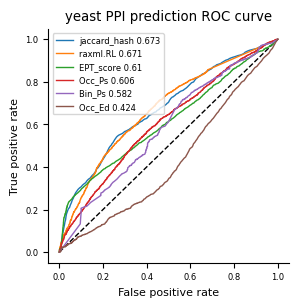

In [13]:
df = nonjaccyes

fig, ax1 = plt.subplots(1, 1, figsize=(3.1,3.1), dpi=100)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)

for i, row in enumerate(df.sort_values(4, ascending=False).values.tolist()):
    ax1.plot(row[5], row[6], label=str(f"{'raxml.RL' if row[1] == 'cotr' else row[1]} {round(row[4], 3)}"), linewidth=1, alpha=1)

ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')

ax1.spines[['right','top']].set_visible(False)
ax1.set_title(f'yeast PPI prediction ROC curve')
plt.legend(loc='upper left')

plt.savefig(f'results.LRvJaccard.pdf')

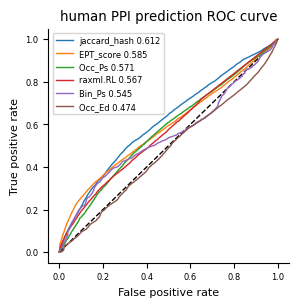

In [14]:
df = nonjacchum

fig, ax1 = plt.subplots(1, 1, figsize=(3.1,3.1), dpi=100)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)

for i, row in enumerate(df.sort_values(4, ascending=False).values.tolist()):
    ax1.plot(row[5], row[6], label=str(f"{'raxml.RL' if row[1] == 'cotr' else row[1]} {round(row[4], 3)}"), linewidth=1, alpha=1)

ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')

ax1.spines[['right','top']].set_visible(False)
ax1.set_title(f'human PPI prediction ROC curve')
plt.legend(loc='upper left')

plt.savefig(f'results.LRvJaccard.human.pdf')

## Sublevels (Metazoa and Fungi)

In [15]:
def getlineage(taxidlist):
    
    Entrez.email = "A.N.Other@example.com"
    handle = Entrez.efetch(db="Taxonomy", id=taxidlist, retmode="xml")
    taxDf = pd.json_normalize(Entrez.read(handle))
    return [(row[0], row[5].split('; ')) 
            for row in taxDf.values.tolist()]

csv_file = glob.glob('../../*raxml*RL*csv')[0]
csv = pd.read_table(csv_file)

taxis = [i.split('_')[0] for i in csv.columns[2:]]
taxis_lineage = [getlineage(t.tolist()) 
                 for t in np.array_split(taxis, int(len(taxis)/400)+1)]
taxis_lineage = list(itertools.chain(*taxis_lineage))

taxonomy_df = pd.DataFrame([(t[0],';'.join(t[1])) for t in taxis_lineage])
taxonomy_df.to_csv('ODB_All_taxidlineage.tsv', sep='\t', index=False, header=None)

In [17]:
csvnum_file = '../../Eukaryota.raxml.RL.csv.num'
csvnum = pd.read_table(csvnum_file, header=None)
lineage = pd.read_table('ODB_All_taxidlineage.tsv', header=None)

fungi = set(lineage[lineage[1].str.contains('Fungi')][0])
fungicols = [(e+1,i) for e,i in enumerate(csv.columns[2:]) if int(i.split('_')[0]) in fungi]

metazoa = set(lineage[lineage[1].str.contains('Metazoa')][0])
metazoacols = [(e+1,i) for e,i in enumerate(csv.columns[2:]) if int(i.split('_')[0]) in metazoa]

csvnumfungi = csvnum[[0]+[i[0] for i in fungicols]]
csvnummetazoa = csvnum[[0]+[i[0] for i in metazoacols]]

csvnumfungipath = os.path.basename(csvnum_file).split('.')[0]+'.Fungi.'+'.'.join(os.path.basename(csvnum_file).split('.')[1:])
csvnummetazoapath = os.path.basename(csvnum_file).split('.')[0]+'.Metazoa.'+'.'.join(os.path.basename(csvnum_file).split('.')[1:])

csvnumfungi.to_csv(csvnumfungipath, sep='\t', index=False, header=None)
csvnummetazoa.to_csv(csvnummetazoapath, sep='\t', index=False, header=None)

In [18]:
csvnumfungipath = 'Eukaryota.Fungi.raxml.RL.csv.num'
csvnummetazoapath = 'Eukaryota.Metazoa.raxml.RL.csv.num'

csv2yeast = 'yeastwopt_odb.tsv'
csv2human = 'humanwopt_odb.tsv'

print(csvnumfungipath, csv2yeast)
print(csvnummetazoapath, csv2human)

!python3 get_transitions_validation.py {csvnumfungipath} {csv2yeast} | procedure_Orthodb_Fisher.r -p 1 -pa 1 - > {csvnumfungipath}.yeast
!python3 get_transitions_validation_jaccard_pearson.py {csvnumfungipath} {csv2yeast} > {csvnumfungipath}.yeast.jaccpear

!python3 get_transitions_validation.py {csvnummetazoapath} {csv2human} | procedure_Orthodb_Fisher.r -p 1 -pa 1 - > {csvnummetazoapath}.human
!python3 get_transitions_validation_jaccard_pearson.py {csvnummetazoapath} {csv2human} > {csvnummetazoapath}.human.jaccpear

Eukaryota.Fungi.raxml.RL.csv.num yeastwopt_odb.tsv
Eukaryota.Metazoa.raxml.RL.csv.num humanwopt_odb.tsv
done transitions
done concordance
calculating probabilities (output table to STDOUT)
9757 gene pairs with p <= 1 and p.adj <= 1
done concordance
done transitions
done concordance
calculating probabilities (output table to STDOUT)
41636 gene pairs with p <= 1 and p.adj <= 1
done concordance


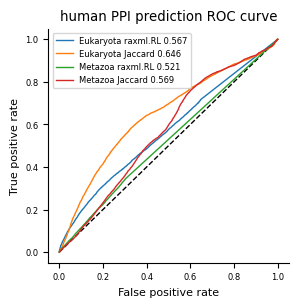

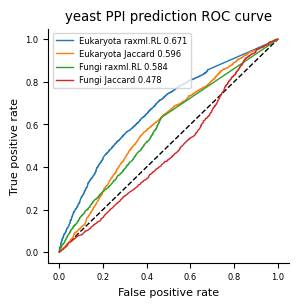

In [19]:
def mergevals(path1, path2):
    
    df = pd.read_table(path1)
    val = pd.read_table(path2).dropna()
    val['ogs'] = val.apply(lambda x: '|'.join(sorted([x['og1'],x['og2']])), axis=1)
    df['ogs'] = df.apply(lambda x: '|'.join(sorted([x['G1'],x['G2']])), axis=1)
    valdf = pd.merge(val, df).drop_duplicates(['ProA','proB'])
    
    return valdf

def getauc(df, score):
    
    fpr, tpr, _ = roc_curve(df['truth'], df[score])
    roc_auc = auc(fpr, tpr)
    
    return [roc_auc, fpr, tpr]

final = []
for typ in ['full','sublevel']:
    for specie in ['yeast','human']:

        taxa = 'Fungi' if specie == 'yeast' else 'Metazoa'
        
        path2 = f'{specie}wopt_odb.tsv'
        if typ == 'sublevel':
            path1 = f'Eukaryota.{taxa}.raxml.RL.csv.num.{specie}'
        else:
            path1 = f'Eukaryota.raxml.RL.csv.num.{specie}'
            

        valdf = mergevals(path1, path2)
        valdf = valdf[valdf['og1']!=valdf['og2']]
        valdf['logp'] = valdf['p'].apply(lambda x: -np.log10(x))
        valdfja = mergevals(path1+'.jaccpear', path2)
        valdfja = valdfja[valdfja['og1']!=valdfja['og2']]

        final.append([typ,specie,taxa,'logp',len(valdf)]+getauc(valdf, 'logp'))
        final.append([typ,specie,taxa,'Jaccard',len(valdfja.dropna(subset=['Jaccard']))]+
                     getauc(valdfja.dropna(subset=['Jaccard']), 'Jaccard'))
        final.append([typ,specie,taxa,'Pearson',len(valdfja.dropna(subset=['Pearson']))]+
                     getauc(valdfja.dropna(subset=['Pearson']), 'Pearson'))
        
final = pd.DataFrame(final)

dfh = final[final[1]=='human']
dfy = final[final[1]=='yeast']

fig, ax1 = plt.subplots(1, 1, figsize=(3.1,3.1), dpi=100)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)

for i, row in enumerate(dfh.sort_values(2, ascending=False).values.tolist()):
    if not row[3] == 'Pearson':
        sublevel = 'Metazoa' if row[0] == 'sublevel' else 'Eukaryota'
        ax1.plot(row[6], row[7], label=str(f"{sublevel} {'raxml.RL' if row[3] == 'logp' else row[3]} {round(row[5], 3)}"), linewidth=1, alpha=1)

ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')

ax1.spines[['right','top']].set_visible(False)
ax1.set_title(f'human PPI prediction ROC curve')
plt.legend(loc='upper left')

plt.savefig(f'results.human.metazoa.pdf')

fig, ax1 = plt.subplots(1, 1, figsize=(3.1,3.1), dpi=100)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)

for i, row in enumerate(dfy.sort_values(2, ascending=False).values.tolist()):
    if not row[3] == 'Pearson':
        sublevel = 'Fungi' if row[0] == 'sublevel' else 'Eukaryota'
        ax1.plot(row[6], row[7], label=str(f"{sublevel} {'raxml.RL' if row[3] == 'logp' else row[3]} {round(row[5], 3)}"), linewidth=1, alpha=1)

ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')

ax1.spines[['right','top']].set_visible(False)
ax1.set_title(f'yeast PPI prediction ROC curve')
plt.legend(loc='upper left')

plt.savefig(f'results.yeast.fungi.pdf')

## OMA vs ODB

In [20]:
c = Client()

for specie_tag in ['yeast', 'human']:
    if specie_tag == 'yeast':
        val = pd.read_csv(f'{specie_tag}w_opt.csv')
    elif specie_tag == 'human':
        val = pd.read_csv(f'{specie_tag}wopt.csv')
    ids = set(val['ProA'])|set(val['proB'])
    mapp = []
    for arr in np.array_split(list(ids), np.ceil(len(ids)/1000)):  ###limit 1000 queries
        r = c.proteins[arr]  # Can also be called as c.proteins.info(prot_id)
        for k,v in r.items():
            if v!=None:
                mapp.append([k, v.get('oma_hog_id')])
            else:
                mapp.append([k, None])
    fin = pd.DataFrame(mapp, columns=['uniprot', 'hog']).dropna()
    fin = fin[fin['hog']!='']
    fin['hog'] = fin['hog'].apply(lambda x: int(x.split('C')[1].split('.')[0]))
    findict = dict(fin.values.tolist())
    val['og1'] = val['ProA'].apply(lambda x: findict.get(x))
    val['og2'] = val['proB'].apply(lambda x: findict.get(x))
    val.to_csv(f"{specie_tag}wopt_oma.tsv", sep='\t', index=False)

In [21]:
for specie in ['yeast','human']:
    
    csv1 = '../../Eukaryota.HOGs.raxml.RL.csv.num'
    csv2 = f'{specie}wopt_oma.tsv'
    exfile = f"{csv1}.{specie}"
    
    print(csv1, csv2, exfile)

    !python3 get_transitions_validation.py {csv1} {csv2} | procedure_Orthodb_Fisher.r -p 1 -pa 1 - > {exfile}
    !python3 get_transitions_validation_jaccard_pearson.py {csv1} {csv2} > {exfile}.jaccpear

Eukaryota.HOGs.raxml.RL.csv.num yeastwopt_oma.tsv Eukaryota.HOGs.raxml.RL.csv.num.yeast
done transitions
done concordance
calculating probabilities (output table to STDOUT)
9891 gene pairs with p <= 1 and p.adj <= 1
done concordance
Eukaryota.HOGs.raxml.RL.csv.num humanwopt_oma.tsv Eukaryota.HOGs.raxml.RL.csv.num.human
done transitions
done concordance
calculating probabilities (output table to STDOUT)
41557 gene pairs with p <= 1 and p.adj <= 1
done concordance


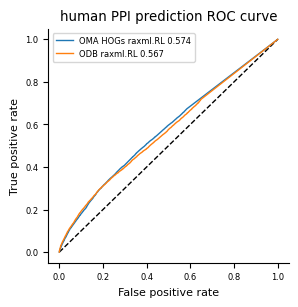

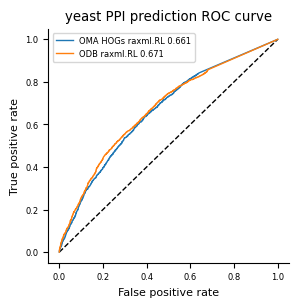

In [22]:
def mergevalsodb(path1, path2):
    
    df = pd.read_table(path1)
    val = pd.read_table(path2).dropna()
    val['ogs'] = val.apply(lambda x: '|'.join(sorted([x['og1'],x['og2']])), axis=1)
    df['ogs'] = df.apply(lambda x: '|'.join(sorted([x['G1'],x['G2']])), axis=1)
    valdf = pd.merge(val, df).drop_duplicates(['ProA','proB'])
    
    return valdf

def mergevalsoma(path1, path2):
    
    df = pd.read_table(path1)
    val = pd.read_table(path2).dropna()
    val['ogs'] = val.apply(lambda x: '|'.join(sorted([str(int(x['og1'])),str(int(x['og2']))])), axis=1)
    df['ogs'] = df.apply(lambda x: '|'.join(sorted([str(int(x['G1'])),str(int(x['G2']))])), axis=1)
    valdf = pd.merge(val, df).drop_duplicates(['ProA','proB'])
    
    return valdf

def getauc(df, score):
    fpr, tpr, _ = roc_curve(df['truth'], df[score])
    roc_auc = auc(fpr, tpr)
    return [roc_auc, fpr, tpr]

final = []
for specie in ['yeast','human']:
    for f in [f'../../Eukaryota.HOGs.raxml.RL', f'../../Eukaryota.raxml.RL']:

        database = 'oma' if 'HOGs' in f else 'odb'
        path2 = f'{specie}wopt_{database}.tsv'
        path1 = f'{f}.csv.num.{specie}'

        valdf = mergevalsoma(path1, path2) if 'HOGs' in path1 else mergevalsodb(path1, path2)
        valdf['logp'] = valdf['p'].apply(lambda x: -np.log10(x))
        
        valdfja = mergevalsoma(path1+'.jaccpear', path2) if 'HOGs' in path1 else mergevalsodb(path1+'.jaccpear', path2)
        
        valdf = valdf[valdf['og1']!=valdf['og2']]
        valdfja = valdfja[valdfja['og1']!=valdfja['og2']]

        final.append([specie,database,'logp',len(valdf)]+getauc(valdf, 'logp'))
        final.append([specie,database,'Jaccard',len(valdfja.dropna(subset=['Jaccard']))]+
                     getauc(valdfja.dropna(subset=['Jaccard']), 'Jaccard'))
        final.append([specie,database,'Pearson',len(valdfja.dropna(subset=['Pearson']))]+
                     getauc(valdfja.dropna(subset=['Pearson']), 'Pearson'))
    
final = pd.DataFrame(final)
dfh = final[final[0]=='human']
dfy = final[final[0]=='yeast']

fig, ax1 = plt.subplots(1, 1, figsize=(3.1,3.1), dpi=100)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)

for i, row in enumerate(dfh.sort_values([1,2], ascending=[False,False]).values.tolist()):
    if row[2] == 'logp':
        ax1.plot(row[5], row[6], label=str(f"{'OMA HOGs' if row[1] == 'oma' else 'ODB'} {'raxml.RL' if row[2] == 'logp' else row[2]} {round(row[4], 3)}"), linewidth=1, alpha=1)

ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')

ax1.spines[['right','top']].set_visible(False)
ax1.set_title(f'human PPI prediction ROC curve')
plt.legend(loc='upper left')

plt.savefig(f'results.omaodb.human.pdf')

fig, ax1 = plt.subplots(1, 1, figsize=(3.1,3.1), dpi=100)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)

for i, row in enumerate(dfy.sort_values([1,2], ascending=[False,False]).values.tolist()):
    if row[2] == 'logp':
        ax1.plot(row[5], row[6], label=str(f"{'OMA HOGs' if row[1] == 'oma' else 'ODB'} {'raxml.RL' if row[2] == 'logp' else row[2]} {round(row[4], 3)}"), linewidth=1, alpha=1)

ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')

ax1.spines[['right','top']].set_visible(False)
ax1.set_title(f'yeast PPI prediction ROC curve')
plt.legend(loc='upper left')

plt.savefig(f'results.omaodb.yeast.pdf')

## HUMAP

In [23]:
xref = pd.read_table('odb10v1_gene_xrefs.9606.tab', header=None)
og2genes = pd.read_table('odb10v1_OG2genes.9606.tab', header=None)

humap_path = 'http://humap2.proteincomplexes.org/static/downloads/humap2'
train_pos = pd.read_table(f'{humap_path}/humap2_train_ppis_ACC_20200818.txt', header=None)
test_pos = pd.read_table(f'{humap_path}/humap2_test_ppis_ACC_20200818.txt', header=None)
train_neg = pd.read_table(f'{humap_path}/humap2_neg_train_ppis_ACC_20200818.txt', header=None)
test_neg = pd.read_table(f'{humap_path}/humap2_neg_test_ppis_ACC_20200818.txt', header=None)

train_pos[2], train_pos[3] = 'yes', 'train'
test_pos[2], test_pos[3] = 'yes', 'test'
train_neg[2], train_neg[3] = 'no', 'train'
test_neg[2], test_neg[3] = 'no', 'test'

df = pd.concat([train_pos,test_pos,train_neg,test_neg])
df.to_csv('HUMAP_set.tsv', sep='\t', index=False, header=None)

allids = set(df[0].tolist()+df[1].tolist())
merged = pd.merge(xref[xref[1].isin(allids)], og2genes.rename(columns={0:3, 1:0}))
merged = merged[merged[3].str.contains('at2759')]
uniog = dict(merged[[1,3]].values.tolist())

df[2] = df[0].apply(lambda x: uniog.get(x))
df[3] = df[1].apply(lambda x: uniog.get(x))

df.columns = ['uni1','uni2','og1','og2']
df.dropna().to_csv('HUMAP_set_odb.tsv', sep='\t', index=None)

csv1 = '../../Eukaryota.raxml.RL.csv.num'
csv2 = 'HUMAP_set_odb.tsv'
exfile = 'Eukaryota.raxml.RL.csv.num.humap'

print(csv1, csv2, exfile)

!python3 get_transitions_validation.py {csv1} {csv2} | procedure_Orthodb_Fisher.r -p 1 -pa 1 - > {exfile}
!python3 get_transitions_validation_jaccard_pearson.py {csv1} {csv2} > {exfile}.jaccpear

dfexf = pd.read_table(exfile)
dfval = pd.read_table(csv2)

dfexf['ogs'] = ['|'.join(sorted([x[0],x[1]])) for x in dfexf[['G1','G2']].values.tolist()]
dfval['ogs'] = ['|'.join(sorted([x[0],x[1]])) for x in dfval[['og1','og2']].values.tolist()]
dfvalfinal = pd.merge(dfexf, dfval, on='ogs')

dfexfja = pd.read_table(exfile+'.jaccpear')
dfvalja = pd.read_table(csv2)

dfexfja['ogs'] = ['|'.join(sorted([x[0],x[1]])) for x in dfexfja[['G1','G2']].values.tolist()]
dfvalja['ogs'] = ['|'.join(sorted([x[0],x[1]])) for x in dfvalja[['og1','og2']].values.tolist()]
dfvalfinalja = pd.merge(dfexfja, dfvalja, on='ogs')

dfvalfinal['unis'] = ['|'.join(sorted([x[0],x[1]])) for x in dfvalfinal[['uni1','uni2']].values.tolist()]
dfvalfinalja['unis'] = ['|'.join(sorted([x[0],x[1]])) for x in dfvalfinalja[['uni1','uni2']].values.tolist()]

humap = pd.read_table('HUMAP_set.tsv', header=None)
# humap = pd.concat([humap[humap[2]=='yes'], humap[humap[2]=='no'].head(len(humap[humap[2]=='yes']))])
humap['unis'] = ['|'.join(sorted([x[0],x[1]])) for x in humap[[0,1]].values.tolist()]

dfvalfinal2 = pd.merge(dfvalfinal, humap[['unis',2]])
dfvalfinalja2 = pd.merge(dfvalfinalja, humap[['unis',2]])

dfvalfinal2 = dfvalfinal2.rename(columns={2: 'truth'})
dfvalfinalja2 = dfvalfinalja2.rename(columns={2: 'truth'})

val = dfvalfinal2[['unis','ogs','truth','p']]
valja = dfvalfinalja2[['unis','ogs','truth','Pearson','Jaccard']]

val['truth'] = val['truth'].apply(lambda x: 1 if x == 'yes' else 0 if x == 'no' else None)
valja['truth'] = valja['truth'].apply(lambda x: 1 if x == 'yes' else 0 if x == 'no' else None)

final = pd.merge(val, valja, on=['unis','ogs','truth'], how='outer')

final = final.drop_duplicates()
final['cotr'] = final['p'].apply(lambda x: -np.log10(x))

Eukaryota.raxml.RL.csv.num HUMAP_set_odb.tsv Eukaryota.raxml.RL.csv.num.humap
done transitions
done concordance
calculating probabilities (output table to STDOUT)
3303795 gene pairs with p <= 1 and p.adj <= 1
done concordance


cotr 0.5764971431603823
Jaccard 0.6318300932541403
Pearson 0.5239178606823499


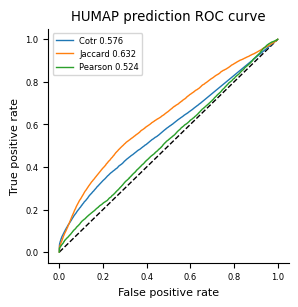

In [24]:
results = []
for score in ['cotr', 'Jaccard', 'Pearson']:

    sub = final.dropna(subset=[score])[[score,'truth']]
    sub = sub[sub[score]!=np.inf]
    y_test = sub.truth
    y_pred = (sub[score]-sub[score].min()
             )/(sub[score].max()-sub[score].min())
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    results.append([score, fpr, tpr, roc_auc])
    print(score, roc_auc)

results = pd.DataFrame(results)

fig, ax1 = plt.subplots(1, 1, figsize=(3.1,3.1), dpi=100)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)

for i, row in enumerate(results.values.tolist()):
    ax1.plot(row[1], row[2], label=str(f"{'Cotr' if row[0] == 'cotr' else row[0]} {round(row[3],3)}"), linewidth=1, alpha=1)

ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')

ax1.spines[['right','top']].set_visible(False)
ax1.set_title(f'HUMAP prediction ROC curve')
plt.legend(loc='upper left')

plt.savefig(f'results.humap.pdf')